# Load libraries

In [1]:
import gc

import numpy as np
import pandas as pd

import datatable as dt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read data

In [2]:
train = pd.read_csv("../input/tabular-playground-series-jan-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-jan-2022/test.csv")

train.drop('row_id', axis=1, inplace=True)
test.drop('row_id', axis=1, inplace=True)

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

train.head()

Train shape: (26298, 5)
Test  shape: (6570, 4)


,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


# Pre-processing

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      26298 non-null  object
 1   country   26298 non-null  object
 2   store     26298 non-null  object
 3   product   26298 non-null  object
 4   num_sold  26298 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     6570 non-null   object
 1   country  6570 non-null   object
 2   store    6570 non-null   object
 3   product  6570 non-null   object
dtypes: object(4)
memory usage: 205.4+ KB


There are **NO missing values** in train and test sets

In [5]:
#######################################
## Datetime processing ## 
#######################################
#Transform to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

#keep datetime as a column
train['date_idx'] = train['date']
test['date_idx'] = test['date']

#set date as index
train = train.set_index('date_idx')
test = test.set_index('date_idx')

#split date to features
#CV ok after drop: 7.07 -> 6.972
#LB nok after drop: 6.34 -> 6.4
train['day'] = train['date'].dt.day
test['day'] = test['date'].dt.day

train['year'] = train['date'].dt.year
test['year'] = test['date'].dt.year

train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

train['dayofyear'] = train['date'].dt.dayofyear
test['dayofyear'] = test['date'].dt.dayofyear

train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek

train['daysinmonth'] = train['date'].dt.days_in_month
test['daysinmonth'] = test['date'].dt.days_in_month


#######################################
## Encoding: country, store, product ## 
#######################################
cols = ['country', 'store', 'product']

#Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in cols:
    train[cat + '_le'] = le.fit_transform(train[cat])
    test[cat + '_le'] = le.transform(test[cat])

# country:  Finland=0,    Norway=1,     Sweden=2
# store:    KaggleMart=0, KaggleRama=1
# product: Kaggle Mug=1,  Kaggle Hat=0, Kaggle Sticker=2

#One-hot encoding
train = pd.concat([train, pd.get_dummies(train[cols], prefix=cols)], axis=1)
test = pd.concat([test, pd.get_dummies(test[cols], prefix=cols)], axis=1)


print('Train shape:', train.shape)
print('Test  shape:', test.shape) 
train.head()

Train shape: (26298, 22)
Test  shape: (6570, 21)


,date,country,store,product,num_sold,day,year,month,dayofyear,dayofweek,...,store_le,product_le,country_Finland,country_Norway,country_Sweden,store_KaggleMart,store_KaggleRama,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker
date_idx,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,1,2015,1,1,3,...,0,1,1,0,0,1,0,0,1,0
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,1,2015,1,1,3,...,0,0,1,0,0,1,0,1,0,0
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,1,2015,1,1,3,...,0,2,1,0,0,1,0,0,0,1
2015-01-01,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,1,2015,1,1,3,...,1,1,1,0,0,0,1,0,1,0
2015-01-01,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,1,2015,1,1,3,...,1,0,1,0,0,0,1,1,0,0


# EDA

### Compare train and test sets

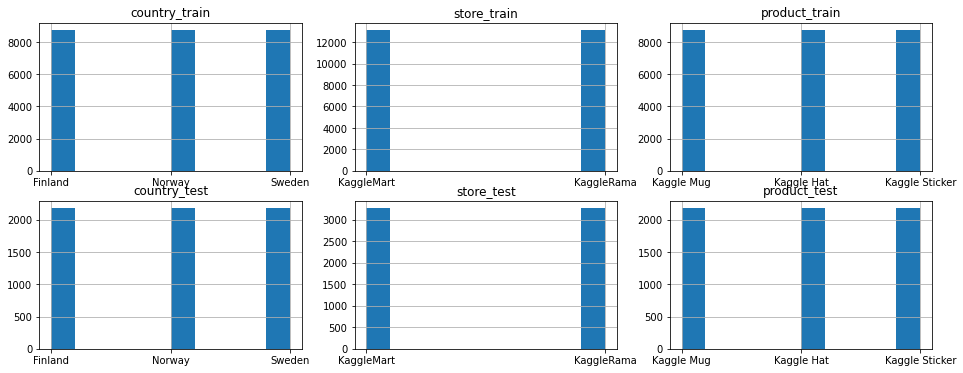

In [6]:
cols = ['country', 'store', 'product']
plt.figure(figsize=(16, 6))
#Train
for val in zip(range(1,4), cols):
    i,col = val
    plt.subplot(2, 3, i)
    plt.title(col+'_train')
    train[col].hist()
#Test set
for val in zip(range(4,7), cols):
    i,col = val
    plt.subplot(2, 3, i)
    plt.title(col+'_test')
    test[col].hist()

**country:** Finland, Norway, Sweden

**store:** KaggleMart, KaggleRama

**product:** KaggleMug, KaggleHat, KaggleSticker

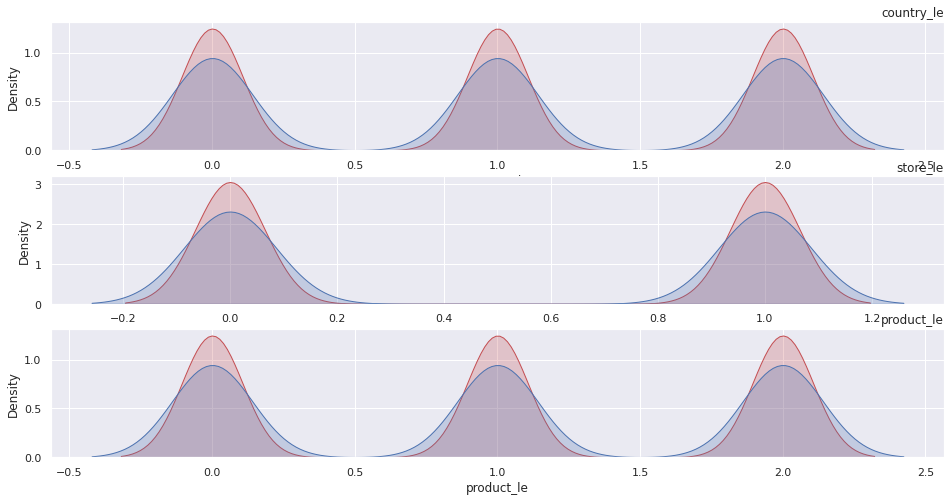

In [7]:
plt.figure(figsize=(16, 8))
sns.set(style="darkgrid")

for val in zip(range(1,4), cols):
    i,col = val
    col = col+'_le'
    plt.subplot(3, 1, i)
    fig = sns.kdeplot(train.reset_index()[col], shade=True, color="r")
    fig = sns.kdeplot(test.reset_index()[col], shade=True, color="b")
    plt.title(col, loc='right')
plt.show()

Train and test sets have very similar distributions

### Plot datetime and num_sold

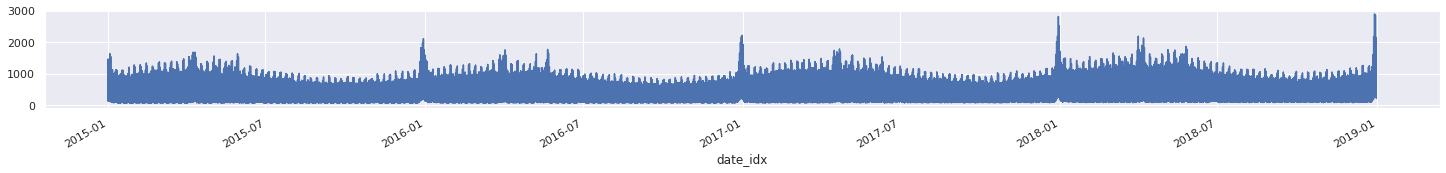

In [8]:
plt.figure(figsize=(25, 2))
train['num_sold'].plot()
plt.show()

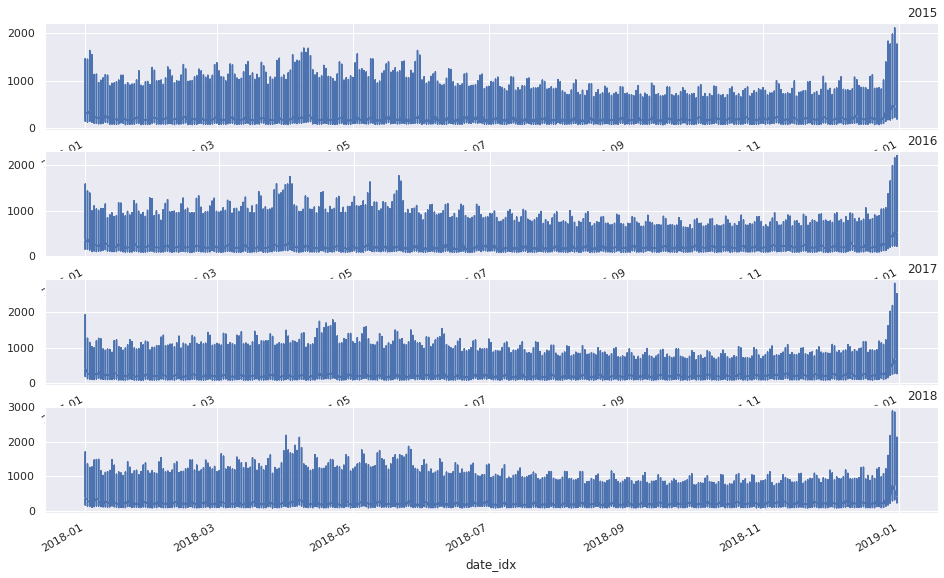

In [9]:
plt.figure(figsize=(16, 10))

for i, year in enumerate(range(2015, 2019)):
    plt.subplot(4, 1, i+1)
    train[train['year'] == year]['num_sold'].plot()
    plt.title(str(year), loc='right')

plt.show()

There is a pattern here. Years are very similar. 

More sales in the 1st part of the year(spring and summer), 

Less sales in the 2nd part of the year(outomn and winter)

Most sales are at the New Year

### December

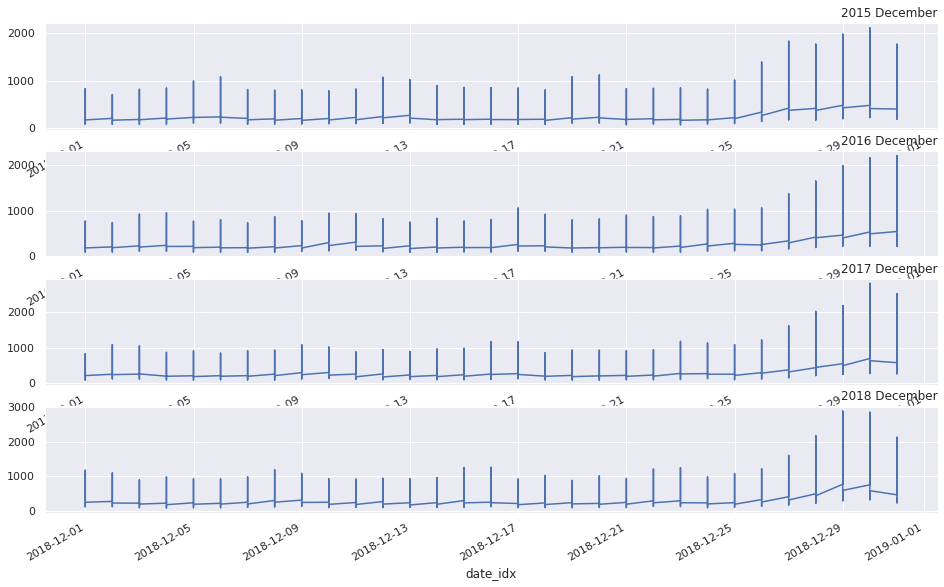

In [10]:
plt.figure(figsize=(16, 10))

for i, year in enumerate(range(2015, 2019)):
    plt.subplot(4, 1, i+1)
    train[(train['year'] == year) & (train['month']==12)]['num_sold'].plot()
    plt.title(str(year)+' December', loc='right')

plt.show()

Sales increase after about December 25th (Christmas) for each year

### April-May

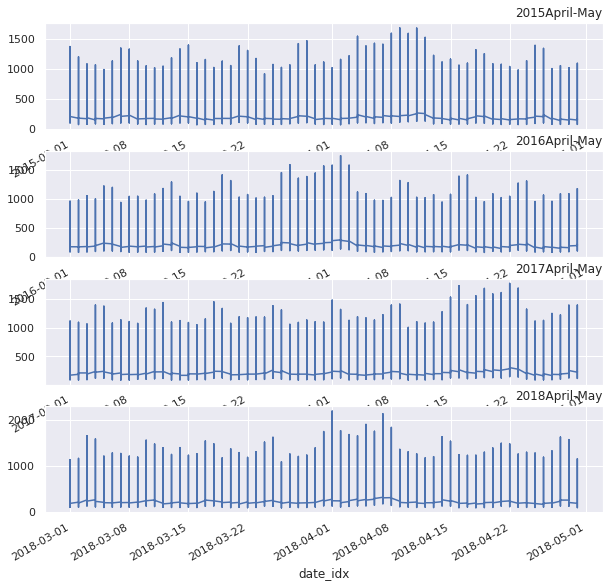

In [11]:
plt.figure(figsize=(10, 10))

for i, year in enumerate(range(2015, 2019)):
    plt.subplot(4, 1, i+1)
    train[(train['year'] == year) & (train['month'].isin(range(3,5)))]['num_sold'].plot()
    plt.title(str(year)+'April-May', loc='right')

plt.show()

### Trends, seasons, cycles

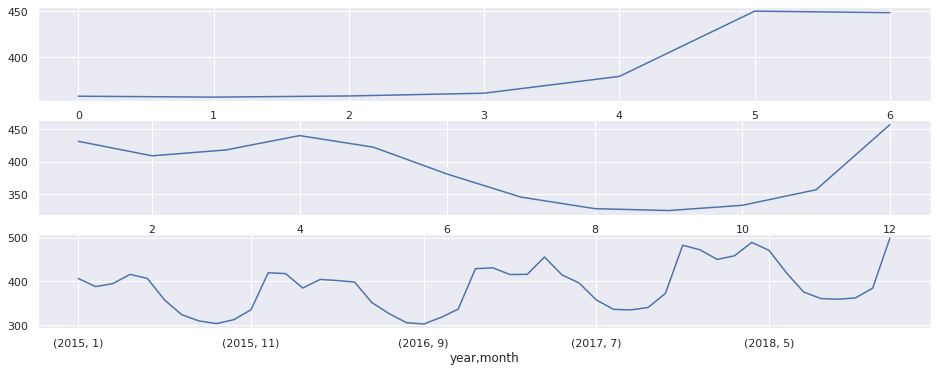

In [12]:
df = train.copy()

plt.figure(figsize=(16,8))

plt.subplot(4, 1, 1)
grouped = df.groupby('dayofweek')["num_sold"].mean()
grouped.plot()

plt.subplot(4, 1, 2)
grouped = df.groupby(['month'])["num_sold"].mean()
grouped.plot()

plt.subplot(4, 1, 3)
grouped = df.groupby(['year', 'month'])["num_sold"].mean()
grouped.plot()

del df
gc.collect()

plt.show()

# Feature engineering

### FEATURES to KEEP

In [13]:
#Spring [3;5]
train['spring'] = train.month.isin(range(3,7))
test['spring'] = test.month.isin(range(3,7))

#std
features = ['day', 'year', 'month', 'dayofyear', 'dayofweek', 'daysinmonth', 'country_Finland', 'country_Norway', 'country_Sweden',
            'store_KaggleMart', 'store_KaggleRama', 'product_Kaggle Hat', 'product_Kaggle Mug', 'product_Kaggle Sticker']
train['std'] = train[features].std(axis=1)
test['std'] = test[features].std(axis=1)

#Christams
train['christmas'] = ((train['month'] == 12) & (train['day'] > 26))
test['christmas'] = ((test['month'] == 12) & (test['day'] > 26))

print('Train shape:', train.shape)
print('Test shape: ', test.shape)

Train shape: (26298, 25)
Test shape:  (6570, 24)


In [14]:
###########################################
## datetime features ##
###########################################

#no change in cv score and in LB
#train['weekend'] = train['dayofweek'] > 4
#test['weekend'] = test['dayofweek'] > 4

#no change in cv score
#train['quarter'] = train['date'].dt.quarter
#test['quarter'] = test['date'].dt.quarter

#no change in cv score
#train['total_seconds'] = train['date'].dt.hour * 3600 + train['date'].dt.minute * 60 + train['date'].dt.second
#test['total_seconds'] = test['date'].dt.hour * 3600 + test['date'].dt.minute * 60 + test['date'].dt.second

#CV LGBM nok, XGBM ok little
#t0 = np.datetime64('2015-01-01')
#train['timedelta'] = (train.date - t0).astype('timedelta64[D]').astype(np.int)
#test['timedelta'] = (test.date - t0).astype('timedelta64[D]').astype(np.int)

#CV nok for all models
#train['weekofyear'] = train.date.dt.weekofyear
#test['weekofyear'] = test.date.dt.weekofyear
###########################################
## seasons features ##
###########################################
#NO it increases CV score just a little, BUT decsrease LB !!!!
#CV ok little: 7.07 -> 6.956213083213457
#LB NOK: 6.34026 -> 7.46133

#CV nok: 7.07 -> 7.21
#train['season_w'] = (train['month'] == 12) | (train['month'] <= 2)
#test['season_w'] = (test['month'] == 12) | (test['month'] <= 2)

#KEEP IT!!!
#CV decr ok: 7.07 -> 7.002
#LB OK: 6.34026(base) -> 6.01857
#train['season_sp'] = train.month.isin(range(3,6))
#test['season_sp'] = test.month.isin(range(3,6))

#CV nothing: 7.07 -> 7.098
#train['season_su'] = train.month.isin(range(6,9))
#test['season_su'] = test.month.isin(range(6,9))

#CV nok: 7.07 -> 7.185
#train['season_o'] = train.month.isin(range(9,12))
#test['season_o'] = test.month.isin(range(9,12))

#--------------------------------------------------- 

#Dec-Jan
#CV nok: 7.07 -> 7.189
#train['season_dec_jan'] = (train['month'] == 12) | (train['month'] == 1)
#test['season_dec_jan'] = (test['month'] == 12) | (test['month'] == 1)

########################################################################
#New Year
#CV nok: 7.07 -> 7.136(<5),
#LB little ok: 6.34026 -> 6.33502
# 7.1419(<=5), 7.136(<5), 7.3(<4), 7.2(<3), 7.197(<2)
#7.136(>24), 7.159(>25), 7.23(>26)
#train['new_year'] = ((train['month'] == 12) & (train['day'] > 24)) | ((train['month'] == 1) & (train['day'] < 5))
#test['new_year'] = ((test['month'] == 12) & (test['day'] > 24)) | ((test['month'] == 1) & (test['day'] < 5))

#Christmas ????
#for >25
#CV nok: 7.07 -> 7.1139
#LB ok: 6.34026 ->  6.29875
#train['christmas_holiday'] = ((train['month'] == 12) & (train['day'] > 25))
#test['christmas_holiday'] = ((test['month'] == 12) & (test['day'] > 25))

#NY
#CV nothing
#train['ny_holiday'] = ((train['month'] == 1) & (train['day'] < 5))
#test['ny_holiday'] = ((test['month'] == 1) & (test['day'] < 5))

#Year part
#CV nothing: 7.07 -> 7.07
#train['year_part_1'] = (train['month'] < 7) & ((train['month'] == 1) & (train['day'] < 5))
#test['year_part_1'] = (test['month'] < 7) & ((test['month'] == 1) & (test['day'] < 5))

#CV nothing: 7.07 -> 7.07
#train['year_part_2'] = (train['month'] >= 7) & ((train['month'] == 12) & (train['day'] > 24))
#test['year_part_2'] = (test['month'] >= 7) & ((test['month'] == 12) & (test['day'] > 24))

#CV nothing
#train['year_idx'] = train['year'].map({2015:0, 2016:1, 2017:2, 2018:3})
#test['year_idx'] = test['year'].map({2015:0, 2016:1, 2017:2, 2018:3})
######################################################
#CV LGBM nok, XGBM nok
#t0 = np.datetime64('2020-01-01')
#train['time_step'] = (t0-train.date).astype('timedelta64[D]').astype(np.int)
#test['time_step'] = (t0-test.date).astype('timedelta64[D]').astype(np.int)
############################################### 
#AGG features
#CV ok for all models for std only
# 7.07 -> 6.904
#Ok for XGB spring+this
"""
features = ['day', 'year', 'month', 'dayofyear', 'dayofweek', 'daysinmonth', 'country_Finland', 'country_Norway', 'country_Sweden',
            'store_KaggleMart', 'store_KaggleRama', 'product_Kaggle Hat', 'product_Kaggle Mug', 'product_Kaggle Sticker']
train['MAX'] = train[features].kurt(axis=1)
test['MAX'] = test[features].kurt(axis=1)
"""

"\nfeatures = ['day', 'year', 'month', 'dayofyear', 'dayofweek', 'daysinmonth', 'country_Finland', 'country_Norway', 'country_Sweden',\n            'store_KaggleMart', 'store_KaggleRama', 'product_Kaggle Hat', 'product_Kaggle Mug', 'product_Kaggle Sticker']\ntrain['MAX'] = train[features].kurt(axis=1)\ntest['MAX'] = test[features].kurt(axis=1)\n"

In [15]:
"""
#CV ok!!!! But Lb NOK!!!
from dateutil.easter import easter
from datetime import timedelta

easters = [np.datetime64(easter(year) - timedelta(1)) for year in range(2015, 2020)]
easters_range = [np.datetime64(easter(year) + timedelta(days=x)) for year in range(2015,2020) for x in range(0,9)]

train['easter'] = train.date.isin(easters_range)
test['easter'] = test.date.isin(easters_range)

print(train['easter'].value_counts())
print(test['easter'].value_counts())
"""

"\n#CV ok!!!! But Lb NOK!!!\nfrom dateutil.easter import easter\nfrom datetime import timedelta\n\neasters = [np.datetime64(easter(year) - timedelta(1)) for year in range(2015, 2020)]\neasters_range = [np.datetime64(easter(year) + timedelta(days=x)) for year in range(2015,2020) for x in range(0,9)]\n\ntrain['easter'] = train.date.isin(easters_range)\ntest['easter'] = test.date.isin(easters_range)\n\nprint(train['easter'].value_counts())\nprint(test['easter'].value_counts())\n"

### Fourie features

In [16]:
#"""
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import re

df = train.copy().to_period('D')

#  freq"A": {"M": 12, "Q": 4},
fourier = CalendarFourier(freq='Y', order=4)
dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

fourier_train = dp.in_sample()
fourier_test = dp.out_of_sample(steps=len(test), forecast_index=test.index)

fourier_train.index = fourier_train.index.astype('datetime64[ns]')

fourier_train = fourier_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
fourier_test = fourier_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train = pd.concat([train, fourier_train], axis=1)
test = pd.concat([test, fourier_test], axis=1)

print(fourier_train.columns)

del df, fourier_train, fourier_test
gc.collect()
#"""

Index(['const', 'trend', 's27', 's37', 's47', 's57', 's67', 's77',
       'sin1freqADEC', 'cos1freqADEC', 'sin2freqADEC', 'cos2freqADEC',
       'sin3freqADEC', 'cos3freqADEC', 'sin4freqADEC', 'cos4freqADEC'],
      dtype='object')


7753

In [17]:
"""
gdp = pd.read_csv('../input/tsp-jan2022-gdp-per-quarter/GDP_Quarterly.csv')
gdp.head()

train['q'] = train.date.dt.quarter
test['q'] = test.date.dt.quarter

gdp['GDP Growth'] = gdp['GDP Growth'].astype('string')
gdp['GDP Growth'] = gdp['GDP Growth'].apply(lambda x: x[:-1])
gdp['GDP Growth'] = gdp['GDP Growth'].astype(float)

def tmp(row):
    return list(gdp[(gdp['Country'] == row['country']) & (gdp['Year'] == row['year']) & (gdp['Quarter'] == 'Q'+str(row['q']))]['GDP Growth'])[0]
    
train['gdp'] = train.apply(tmp, axis=1)
print('train done')
test['gdp'] = test.apply(tmp, axis=1)
print('test done')

train.drop('q', inplace=True, axis=1)
test.drop('q', inplace=True, axis=1)
gc.collect()
"""

"\ngdp = pd.read_csv('../input/tsp-jan2022-gdp-per-quarter/GDP_Quarterly.csv')\ngdp.head()\n\ntrain['q'] = train.date.dt.quarter\ntest['q'] = test.date.dt.quarter\n\ngdp['GDP Growth'] = gdp['GDP Growth'].astype('string')\ngdp['GDP Growth'] = gdp['GDP Growth'].apply(lambda x: x[:-1])\ngdp['GDP Growth'] = gdp['GDP Growth'].astype(float)\n\ndef tmp(row):\n    return list(gdp[(gdp['Country'] == row['country']) & (gdp['Year'] == row['year']) & (gdp['Quarter'] == 'Q'+str(row['q']))]['GDP Growth'])[0]\n    \ntrain['gdp'] = train.apply(tmp, axis=1)\nprint('train done')\ntest['gdp'] = test.apply(tmp, axis=1)\nprint('test done')\n\ntrain.drop('q', inplace=True, axis=1)\ntest.drop('q', inplace=True, axis=1)\ngc.collect()\n"

In [18]:
"""
train['q'] = train.date.dt.quarter
test['q'] = test.date.dt.quarter
gdp['GDP Growth'] = gdp['GDP Growth'].astype('string')
gdp['GDP Growth'] = gdp['GDP Growth']

def tmp(row):
    return list(gdp[(gdp['Country'] == row['country']) & (gdp['Year'] == row['year']) & (gdp['Quarter'] == 'Q'+str(row['q']))]['GDP'])[0].replace(',', '.')
    
train['gdp'] = train.apply(tmp, axis=1)
print('train done')
test['gdp'] = test.apply(tmp, axis=1)
print('test done')

train.drop('q', inplace=True, axis=1)
test.drop('q', inplace=True, axis=1)
gc.collect()
"""

"\ntrain['q'] = train.date.dt.quarter\ntest['q'] = test.date.dt.quarter\ngdp['GDP Growth'] = gdp['GDP Growth'].astype('string')\ngdp['GDP Growth'] = gdp['GDP Growth']\n\ndef tmp(row):\n    return list(gdp[(gdp['Country'] == row['country']) & (gdp['Year'] == row['year']) & (gdp['Quarter'] == 'Q'+str(row['q']))]['GDP'])[0].replace(',', '.')\n    \ntrain['gdp'] = train.apply(tmp, axis=1)\nprint('train done')\ntest['gdp'] = test.apply(tmp, axis=1)\nprint('test done')\n\ntrain.drop('q', inplace=True, axis=1)\ntest.drop('q', inplace=True, axis=1)\ngc.collect()\n"

In [19]:
"""
gdp = pd.read_csv("../input/gdp-per-capita-finland-norway-sweden-201519/GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv")
def tmp(row):
    return list(gdp[(gdp['year'] == row['year'])][row['country']])[0]
    
train['gdp'] = train.apply(tmp, axis=1)
print('train done')
test['gdp'] = test.apply(tmp, axis=1)
print('test done')

gc.collect()
"""

'\ngdp = pd.read_csv("../input/gdp-per-capita-finland-norway-sweden-201519/GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv")\ndef tmp(row):\n    return list(gdp[(gdp[\'year\'] == row[\'year\'])][row[\'country\']])[0]\n    \ntrain[\'gdp\'] = train.apply(tmp, axis=1)\nprint(\'train done\')\ntest[\'gdp\'] = test.apply(tmp, axis=1)\nprint(\'test done\')\n\ngc.collect()\n'

# Drop redundent columns

In [20]:
#reset index
train.reset_index(inplace=True)
test.reset_index(inplace=True)

#drop columns
#'s47'
cols_drop = ['s47','store_KaggleRama','const','date_idx', 'date', 'country', 'store', 'product', 'country_le', 'store_le', 'product_le']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

print('Train shape:', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape: (26298, 31)
Test shape:  (6570, 30)


,num_sold,day,year,month,dayofyear,dayofweek,daysinmonth,country_Finland,country_Norway,country_Sweden,...,s67,s77,sin1freqADEC,cos1freqADEC,sin2freqADEC,cos2freqADEC,sin3freqADEC,cos3freqADEC,sin4freqADEC,cos4freqADEC
0,329,1,2015,1,1,3,31,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,520,1,2015,1,1,3,31,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,146,1,2015,1,1,3,31,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,572,1,2015,1,1,3,31,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,911,1,2015,1,1,3,31,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [21]:
X = train.drop('num_sold', axis=1)
y = train['num_sold']

# Scaling

In [22]:
#StandardScaler MinMaxScaler RobustScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
scaled = ss.fit_transform(X)
X = pd.DataFrame(scaled, index=X.index, columns=X.columns)
scaled = ss.transform(test)
test = pd.DataFrame(scaled, index=test.index, columns=test.columns)


# Model

In [23]:
def smape(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def cross_val_model(X, test, model, nfolds=5, early_stopping_rounds=10, verbose=0):
    oof_pred  = np.zeros(len(X)) 
    oof_label = np.zeros(len(X))
    preds_test = np.zeros(len(test))
    fi = np.zeros(test.shape[1])
    
    nfolds=nfolds
    ts_split = TimeSeriesSplit(n_splits=nfolds)
    
    for fold, (trn_idx, val_idx) in enumerate(ts_split.split(X)):
        print(f"FOLD: {fold}")
        
        X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_valid = y.iloc[trn_idx], y.iloc[val_idx]

        model.fit(X_train, 
                  y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  early_stopping_rounds=early_stopping_rounds,
                  verbose=verbose
                 )
        
        preds_valid = model.predict(X_valid)
        oof_pred[val_idx]  = preds_valid 
        oof_label[val_idx] = y_valid 
        
        error =  np.sqrt(mean_squared_error(y_valid, preds_valid))
        print(f'RMSE: {error}')
        print(f'SMAPE: {smape(y_valid, preds_valid)}')
        print("-"*50)
        
        preds_test += (model.predict(test)) / nfolds
        
        fi += (model.feature_importances_) / nfolds
    
    global_error = np.sqrt(mean_squared_error(oof_label, oof_pred))
    print(' '* 17, 'CLOBAL ERROR')
    print('-' * 50)
    print(f'RMSE: {global_error}...')
    print(f'SMAPE: {smape(oof_label, oof_pred)}...')
    print('-' * 50)
    print()
    
    return preds_test, fi

In [24]:
preds_test = {}
fi_dic = {}
nfolds=5

### LGBM

In [25]:
%%time
nfolds=5
params_lgbm = {'metric': 'rmse',
               'n_estimators': 12000,
               'learning_rate': 0.1,
              }
model_lgbm5 = LGBMRegressor(**params_lgbm)
preds, fi = cross_val_model(X, test, model_lgbm5, nfolds=nfolds, early_stopping_rounds=10, verbose=0)
preds_test['lgbm'] = preds
fi_dic['lgbm'] = fi
#Base CV: 7.070635049674399 -> #Baseline LB: 6.34026
#CV spring: 7.002091900455531
#CV spring+std+mimmaxsc: 6.789913338426887 -> LB: 5.59820 OK, improved)
#CV christmas: 6.804370429485133
##################################CV easter: 6.500504539201466, Lb NOK!!!
#New base=spring(+June),std,christams
#Base: 6.737364844834473
#Fourie(Y,4): 6.56224570301085
#Drop s47: 6.545874374046096

FOLD: 0
RMSE: 89.03634384956435
SMAPE: 11.576594160940791
--------------------------------------------------
FOLD: 1
RMSE: 41.856885628547154
SMAPE: 6.69668024397309
--------------------------------------------------
FOLD: 2
RMSE: 52.979495584039505
SMAPE: 7.421576164284533
--------------------------------------------------
FOLD: 3
RMSE: 59.16686521685523
SMAPE: 7.347863231323176
--------------------------------------------------
FOLD: 4
RMSE: 44.328516614258426
SMAPE: 6.232532443754968
--------------------------------------------------
                  CLOBAL ERROR
--------------------------------------------------
RMSE: 54.69922558526841...
SMAPE: 6.545874374046096...
--------------------------------------------------

CPU times: user 6.25 s, sys: 78.6 ms, total: 6.33 s
Wall time: 1.62 s


### XGBoost

In [26]:
%%time
from xgboost import XGBRegressor
params_xgb = {'eval_metric':'rmse',
              'n_estimators': 10000,
              'learning_rate': 0.1, #default is 0.3, baseline=0.1
              #'seed': 15
            }
model_xgb = XGBRegressor(**params_xgb)
preds, fi = cross_val_model(X, test,model_xgb , nfolds=nfolds, early_stopping_rounds=10, verbose=0)
preds_test['xgb'] = preds
fi_dic['xgb'] = fi
#Base CV: 6.966445446605708 -> #Baseline LB: 6.39483
#CV spring: 6.9115349975236295
#CV spring+std+mimmaxsc: 6.77332047882184 -> LB: 5.59820 OK, improved)
#CV christmas: 6.717673636294565
##################################CV easter: 6.275355923312519
#Base: 6.704671819096818
#Fourie(Y,4): 6.391136332842521
#Drop s47: 6.2961716330044455

FOLD: 0
RMSE: 90.27623577741741
SMAPE: 10.686967732542199
--------------------------------------------------
FOLD: 1
RMSE: 39.41350631224148
SMAPE: 6.017667205333967
--------------------------------------------------
FOLD: 2
RMSE: 54.85810825726406
SMAPE: 7.312151103272412
--------------------------------------------------
FOLD: 3
RMSE: 57.89129547764208
SMAPE: 7.087972417880453
--------------------------------------------------
FOLD: 4
RMSE: 45.946636764061545
SMAPE: 6.672271338997668
--------------------------------------------------
                  CLOBAL ERROR
--------------------------------------------------
RMSE: 55.03806378246927...
SMAPE: 6.2961716330044455...
--------------------------------------------------

CPU times: user 26.1 s, sys: 34 ms, total: 26.1 s
Wall time: 7.03 s


In [27]:
nfolds = 4
print('\n\n##### LGBM ##### nfolds=', nfolds)
model_lgbm4 = LGBMRegressor(**params_lgbm)
name = 'lgbm_' + str(nfolds)
preds, fi = cross_val_model(X, test, model_lgbm4, nfolds=nfolds, early_stopping_rounds=10, verbose=0)
preds_test[name] = preds
fi_dic[name] = fi
#CV: 6.220029353092939
#CV christmas: 6.10991220189296
##################################CV easter: 5.662454058264622
#Base: 6.151975158953347
#Fourie(Y,4): 5.7313597021879215
#Drop s47: 5.736614376355737

print('\n##### XGB ##### nfolds=', nfolds)
name = 'xgb_' + str(nfolds)
preds, fi = cross_val_model(X, test, XGBRegressor(**params_xgb), nfolds=nfolds, early_stopping_rounds=10, verbose=0)
preds_test[name] = preds
fi_dic[name] = fi
#CV: 6.060048967467807
#CV christmas: 6.04690805610541
##################################CV easter: 5.6363388201714955
#Base: 5.978160580623895
#Fourie(Y,4): 5.772289082739235
#Drop s47: 5.781720170259437



##### LGBM ##### nfolds= 4
FOLD: 0
RMSE: 75.28988700369334
SMAPE: 8.694358789947929
--------------------------------------------------
FOLD: 1
RMSE: 53.49877894431865
SMAPE: 7.126795689384547
--------------------------------------------------
FOLD: 2
RMSE: 43.84914431748875
SMAPE: 5.963201859410557
--------------------------------------------------
FOLD: 3
RMSE: 53.29210855939838
SMAPE: 6.9019879984699575
--------------------------------------------------
                  CLOBAL ERROR
--------------------------------------------------
RMSE: 51.559608694155095...
SMAPE: 5.736614376355737...
--------------------------------------------------


##### XGB ##### nfolds= 4
FOLD: 0
RMSE: 85.40658427289425
SMAPE: 9.110719120443099
--------------------------------------------------
FOLD: 1
RMSE: 57.061473304834905
SMAPE: 7.087501379108559
--------------------------------------------------
FOLD: 2
RMSE: 44.93574289195621
SMAPE: 6.042559681426198
-----------------------------------------------

In [28]:
model = LGBMRegressor(**params_lgbm)
model.fit(X, 
          y, 
          eval_set=[(X, y)], 
          early_stopping_rounds=10,
          verbose=1000
         )
 
print(smape(y, model.predict(X)))
preds_lgb_full = model.predict(test)

[1000]	training's rmse: 17.0718
[2000]	training's rmse: 13.7561
[3000]	training's rmse: 11.5381
[4000]	training's rmse: 9.97357
[5000]	training's rmse: 8.75567
[6000]	training's rmse: 7.77479
[7000]	training's rmse: 6.94885
[8000]	training's rmse: 6.28943
[9000]	training's rmse: 5.70867
[10000]	training's rmse: 5.22408
[11000]	training's rmse: 4.80165
[12000]	training's rmse: 4.43529
1.0149432368060674


# AVG of models

In [29]:
avg_df = pd.DataFrame(preds_test)
avg_df['AVG'] = avg_df.mean(axis=1)
avg_df['lgb_full'] = preds_lgb_full
avg_df['AVG_mean'] = avg_df.mean(axis=1)

preds_final = avg_df['AVG_mean']
avg_df.head(10)

,lgbm,xgb,lgbm_4,xgb_4,AVG,lgb_full,AVG_mean
0,336.751786,352.850861,356.125343,355.386169,350.278540,394.100325,357.582171
1,536.188476,573.837654,527.638631,544.322464,545.496806,627.417844,559.150312
2,151.782174,155.760345,147.928504,158.630623,153.525412,201.986419,161.602246
3,614.702186,596.781296,631.588584,589.950119,608.255546,691.809321,622.181175
4,962.365248,998.383408,959.173901,947.892792,966.953837,1109.217242,990.664405
5,275.394503,277.860703,291.414076,281.949482,281.654691,349.827518,293.016829
6,531.723621,547.833328,559.976861,524.325050,540.964715,653.112217,559.655965
7,816.736000,844.377167,825.158685,806.373581,823.161358,951.764592,844.595230
8,230.215123,247.276943,255.465180,234.641941,241.899797,328.871503,256.395081
9,922.003140,966.345856,941.538059,942.182297,943.017338,1097.725871,968.802094


In [30]:
# Round
#preds_final = avg_df['AVG'].apply(np.ceil)
#preds_final

# Feature importance

74

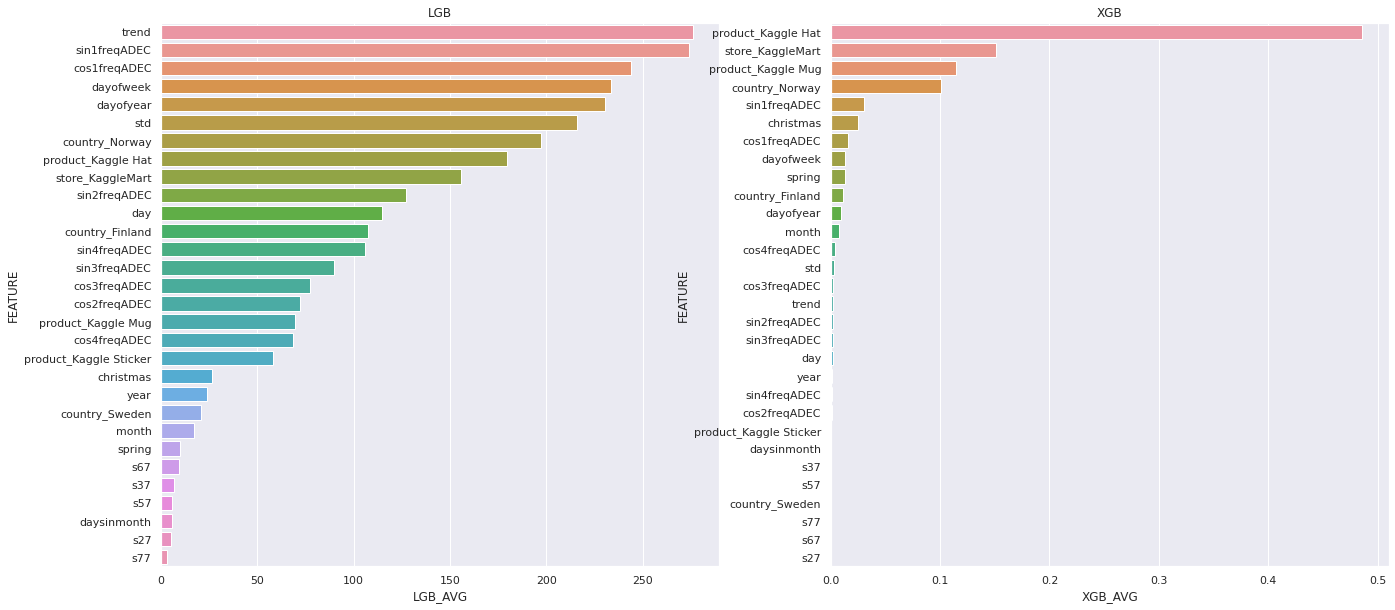

In [31]:
fi_df = pd.DataFrame(fi_dic)
fi_df.insert(loc=0, column='FEATURE', value=test.columns)
fi_df['LGB_AVG'] = fi_df[['lgbm', 'lgbm_4']].mean(axis=1)
fi_df['XGB_AVG'] = fi_df[['xgb', 'xgb_4']].mean(axis=1)

lgb = fi_df[['FEATURE', 'LGB_AVG']].sort_values(by=['LGB_AVG'], ascending=False)
xgb = fi_df[['FEATURE', 'XGB_AVG']].sort_values(by=['XGB_AVG'], ascending=False)

plt.figure(figsize=(22,10))

plt.subplot(1, 2, 1)
plt.title('LGB')
sns.barplot(y=lgb['FEATURE'], x=lgb['LGB_AVG'])

plt.subplot(1, 2, 2)
plt.title('XGB')
sns.barplot(y=xgb['FEATURE'], x=xgb['XGB_AVG'])


del lgb, xgb
gc.collect()

# Submit

In [32]:
%%time
output = pd.read_csv('../input/tabular-playground-series-jan-2022/sample_submission.csv')
output['num_sold'] = preds_final 
output.to_csv('submission_lgbm_xgb.csv', index=False)

CPU times: user 16.3 ms, sys: 1 ms, total: 17.3 ms
Wall time: 28.7 ms


In [33]:
print('The end!')

The end!
